In [9]:
import math
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import empyrical as empy
from sklearn.metrics import (
    precision_score, accuracy_score, confusion_matrix, 
    mean_squared_error, recall_score, f1_score
)

import itertools

import dataframe_image as dfi
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [10]:
# price_data_name = 'data/backtest_etf_algo_corr_fsp_20220829.csv'
# result_excel_name = './result/2022/MPT_kpi/1.5.1b/digital_twins_KPIs_151b_agg.xlsx'

price_data_name = './result/2022/cashON_signal/result/long_hist/backtest_AML_ETF_2000_202205.csv'
result_excel_name = './result/2022/cashON_signal/result/long_hist/config_aml1983_withlongpred_with_newp_Agg_oldconfig_newbl_68-2205.xlsx'
client = 'agg'

comm_ratio = 0.0001
annual_interest = 0.0158
vote_down_buy_ratio_list = [0, 0.1, 0.2, 0.3]

start = '1987'
end = '2022-07'

In [16]:
def display_df(df, export_img=False, **kwargs):
    df_style = df.style.background_gradient(**kwargs)
    display(df_style)
    
    if export_img:
        try:
            dfi.export(df_style,"tmp.png",table_conversion='matplotlib')
            display(Image("tmp.png"))
        except:
            pass

def show_cum_ret(ret):
    fig, ax = plt.subplots(figsize=(24,15))
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = ret.shape[1]
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    (1+ret).cumprod().plot(ax=ax)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    plt.show()


def read_kpi2ret(result_excel_name, start=None, end=None):
    hist = pd.read_excel(result_excel_name, index_col=0, sheet_name='History')
    hist.index = pd.to_datetime(hist.index)
    balance = hist['Balance']
    balance_ = pd.concat([pd.Series(1e9),balance])
    ret = balance_.pct_change().ffill().dropna()
    ret.index = pd.to_datetime(ret.index)
    if start is not None:
        ret = ret[start:]
    if end is not None:
        ret = ret[:end]
    return ret

In [6]:
def correct_return(ret, factor):
    ret_ = (1+ret)*factor - 1
    return ret_

def add_lev_cost_to_ret(ret, lev, annual_interest=annual_interest):
    
    balance = return_to_price(ret).iloc[1:]
    cash = (1-lev)*balance
    
    """
    balance = hist['Balance']
    balance_ = pd.concat([pd.Series(1e9), balance])
    ret = balance_.pct_change().ffill().dropna()
    """
    
    '''
    monthly_credit = hist['cash'].groupby(pd.Grouper(freq='M')).min()
    idx = hist.index.to_series()
    idx_month_end = idx.groupby(pd.Grouper(freq='M')).max()
    monthly_credit.index = idx_month_end.values
    
    lev_cost = monthly_credit.apply(lambda x: -x*annual_interest/12 if x<0 else 0)
    lev_cost = lev_cost.reindex(balance.index).fillna(0)
    '''
    # cost calculated daily, billed at month end
    daily_credit = cash.apply(lambda x: x if x<0 else 0)
    daily_lev_cost = daily_credit.apply(lambda x: -x*annual_interest/252 if x<0 else 0)
    
    
    #display(daily_lev_cost)
    
    
    monthy_lev_cost = daily_lev_cost.groupby(pd.Grouper(freq='M')).sum()
    
    idx = hist.index.to_series()
    idx_month_end = idx.groupby(pd.Grouper(freq='M')).max()
    
    
    #print(monthy_lev_cost)
    #print(idx_month_end)
    
    
    
    
    #monthy_lev_cost.index = idx_month_end.values
    monthy_lev_cost.index = idx_month_end.reindex(monthy_lev_cost.index).values
    
    
    
    lev_cost = monthy_lev_cost.reindex(balance.index).fillna(0)
    
    lev_cost_correct_factor = 1 - lev_cost/balance
    
    ret_lev_cost_correct = correct_return(ret, lev_cost_correct_factor)
    
    return ret_lev_cost_correct


In [7]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error

def _drawdown_from_price(price):
    shift_max = price.copy()
    _max = price.iloc[0]
    for i, j in price.items():
        #print('i', i)
        #print('j', j)
        _max = max(_max, j)
        shift_max[i] = _max
    return price / shift_max - 1

def return_to_price(ret, ini=100):
    price_0 = ret.dropna().iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])

def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]

def avg_drawdown(ret):
    dd = drawdown_from_return(ret)
    return dd.mean()

def empy_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(empy_metric).T
    total_return = lambda x: (1+x).prod()-1
    met_func = [
        total_return, 
        lambda x: empy.annual_return(x), 
        lambda x: empy.sharpe_ratio(x), 
        lambda x: empy.annual_volatility(x), 
        lambda x: empy.max_drawdown(x), 
        avg_drawdown]
    
    met_func_names = ['total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
                      'max_drawdown', 'avg_drawdown',]
    
    se = pd.Series([f(ret) for f in met_func], met_func_names)
    
    se['return/maxdd'] = -se.annual_return/se.max_drawdown
    se['return/avgdd'] = -se.annual_return/se.avg_drawdown
    
    #buy01 = ret.apply(lambda x: 0 if x==0 else 1)
    #se['buy_ratio'] = buy01.mean()
    #se['flip_ratio'] = (buy01-buy01.shift()).abs().mean()
    
    return se

#ewma = lambda x, y: x.ewm(span=y).mean()


def cal_metric(y_true, y_pred):

    if isinstance(y_pred, pd.DataFrame):
        prec_ser = pd.Series(index=y_pred.columns, name='precision')
        acccc_ser = pd.Series(index=y_pred.columns, name='accuracy')
        recall_ser = pd.Series(index=y_pred.columns, name='recall')
        recall0_ser = pd.Series(index=y_pred.columns, name='recall0')
        f1_score_ser = pd.Series(index=y_pred.columns, name='f1_score')
        f0_score_ser = pd.Series(index=y_pred.columns, name='f0_score')
        for col in y_pred.columns:
            # print("   *********************************  ", col)
            if isinstance(y_true, pd.DataFrame):
                tmp_y_true = y_true[col]
            else:
                tmp_y_true = y_true.copy()
            prec_ser[col], acccc_ser[col], recall_ser[col], recall0_ser[col], f1_score_ser[col], f0_score_ser[col] = cal_metric(
                tmp_y_true, y_pred[col])
        return prec_ser, acccc_ser, recall_ser, recall0_ser, f1_score_ser, f0_score_ser

    y_true = y_true.reindex(y_pred.index)
    tmp = pd.concat([y_true, y_pred], axis=1).dropna()
    y_true = tmp.iloc[:, 0]
    y_pred = tmp.iloc[:, -1]
    # print("y_pred\n", y_pred)
    # print("y_true\n", y_true)
    # pd.concat([y_proba, y_pred, y_pctch, y_true, ydelta_true], axis=1).to_csv("./tmp/{}.csv".format(y_pctch.name))

    try:
        prec = precision_score(y_true=y_true, y_pred=y_pred)
        acccc = accuracy_score(y_true=y_true, y_pred=y_pred)
    except Exception as e:
        print(e)
        prec = 0
        acccc = 0

    try:
        recall = recall_score(y_true=y_true, y_pred=y_pred)
        recall0 = recall_score(y_true=y_true, y_pred=y_pred, pos_label=0)
    except Exception as e:
        print(e)
        recall = 0
        recall0 = 0

    try:
        f1score = f1_score(y_true=y_true, y_pred=y_pred)
        f0score = f1_score(y_true=y_true, y_pred=y_pred, pos_label=0)
    except Exception as e:
        print(e)
        f1score = 0
        f0score = 0
    # print("mse, mse_proba, msefullscore, msefullscore_ret, prec, acccc, recall, recall0")
    # print(mse, mse_proba, msefullscore, msefullscore_ret, prec, acccc, recall, recall0)
    return prec, acccc, recall, recall0, f1score, f0score

In [ ]:
hist = pd.read_excel(result_excel_name, index_col=0, sheet_name='History')
hist.index = pd.to_datetime(hist.index)
balance = hist['Balance']
# balance_ = pd.concat([pd.Series(1e9),balance])
# ret = balance_.pct_change().ffill().dropna()
# ret.index = pd.to_datetime(ret.index)
# # ret = ret[start:end]
# ret_comm_correct = ret[start:end]
# ret_comm_correct

In [ ]:
close_ratio = hist.iloc[:, 9:]
close_ratio = close_ratio.sort_index(axis=1)
open_not_traded_ratio = close_ratio.shift().fillna(0)
price = pd.read_csv(price_data_name, index_col=0)
price = price.pivot_table('adj_close', 'date', 'code')
price.index = pd.to_datetime(price.index)
price_change = price.pct_change().fillna(0)
price_change = price_change.reindex(close_ratio.index)
open_traded_ratio = close_ratio/(1+price_change)
trade_diff = (open_traded_ratio - open_not_traded_ratio).applymap(abs)
sum_abs_trade_diff = trade_diff.applymap(abs).sum(axis=1)

comm = sum_abs_trade_diff*comm_ratio
comm_correct_factor = 1 - comm/balance

ret_comm_correct = correct_return(ret, comm_correct_factor)
ret_comm_correct = ret_comm_correct[start:end]
ret_comm_correct

In [ ]:
preds_folder = 'result/2022/202205v0_till202208/pp10/'

vote_csvs = []
for f in os.listdir(preds_folder):
    if os.path.isdir(os.path.join(preds_folder, f)):
        for ff in os.listdir(os.path.join(preds_folder, f)):
            if ff.startswith('3voteContNdays_'):
                vote_csvs.append(os.path.join(preds_folder, f, ff))

vote_csvs

In [24]:
# vote_csvs = [
#     './result/2022/portfolioY/3voteContNdays_yv_ppv_x37asset_v1.csv'
# ]
vote_csvs = [
    './result/2022/cashON_signal/result/long_hist/corr_threshold_longhist_v2/corr_threshold_longhist_v2.csv',
    './result/2022/cashON_signal/result/long_hist/corr_threshold_longhist_v2/corr_threshold_longhist_v2-combine2condition.csv'
]

In [27]:
# all_vote_down_buy_ratio_list = []
# for vote_file in vote_csvs:
#     # 'result/2022/202205v0_till202208/pp10/vote-pp10-Top10_byAccuracy-2022-Aug-24\\3voteContNdays_202205v0_till202208_Top10_byAccuracy.csv'
#     head, tail = os.path.split(vote_file)
#     casename = tail.replace('3voteContNdays_202205v0_till202208_', "").replace('.csv', "")
#     vote_down_buy_ratio_csv = vote_file.replace('3voteContNdays_', 'vote_down_buy_ratio_')
#     vote_all_kinds_return_correct_comm_csv = vote_file.replace('3voteContNdays_', 'returnWithComm_')

#     #vote_down_buy_ratio_csv = 'vote_ml_202205v0_all_kinds_ext_yv_ppv_x37asset.csv'
#     #vote_all_kinds_return_correct_comm_csv = 'met_vote_ml_mpt151b_all_kinds_ext_yv_ppv_x37asset.csv'
#     try: 
#         vote_down_buy_ratio_df = pd.read_csv(vote_down_buy_ratio_csv, index_col=0)
#         vote_down_buy_ratio_df.index = pd.to_datetime(vote_down_buy_ratio_df.index)

#     except:
#         vote_df = pd.read_csv(vote_file, index_col=0)
#         vote_df.index = pd.to_datetime(vote_df.index)
#         vote_freq_cont_df = vote_df[start:end].reindex(ret.index).ffill()

#         vote_down_buy_ratio_df_list = []
#         for vote_down_buy_ratio in vote_down_buy_ratio_list:
#             v = vote_freq_cont_df.applymap(lambda x: vote_down_buy_ratio if x<0.5 else 1)
#             v.columns = v.columns.map(lambda x: x+'___vote_down_buy_{}'.format(vote_down_buy_ratio))
#             vote_down_buy_ratio_df_list.append(v)
#         vote_down_buy_ratio_df = pd.concat(vote_down_buy_ratio_df_list, 1)
#         vote_down_buy_ratio_df.to_csv(vote_down_buy_ratio_csv)
#     all_vote_down_buy_ratio_list.append(vote_down_buy_ratio_df)
# all_vote_down_buy_ratio_df = pd.concat(all_vote_down_buy_ratio_list, 1)
# all_vote_down_buy_ratio_df

In [11]:
all_vote_down_buy_ratio_df = pd.read_csv(vote_down_buy_ratio_csv, index_col=0)#, usecols=list(range(0, 45493))
all_vote_down_buy_ratio_df.index = pd.to_datetime(all_vote_down_buy_ratio_df.index)

In [28]:
all_vote_down_buy_ratio_df = pd.DataFrame()
for vote_file in vote_csvs:
    df = pd.read_csv(vote_file, index_col=0)
    df.index = pd.to_datetime(df.index)
    all_vote_down_buy_ratio_df = pd.concat([all_vote_down_buy_ratio_df, df], axis=1)
all_vote_down_buy_ratio_df = all_vote_down_buy_ratio_df.shift()

In [29]:
all_vote_down_buy_ratio_df = all_vote_down_buy_ratio_df.reindex(ret_comm_correct.index)
all_vote_down_buy_ratio_df.shape

(9208, 41147)

In [30]:
sum_vote_down_buy_ratio_df = all_vote_down_buy_ratio_df.sum()[(all_vote_down_buy_ratio_df.sum()/all_vote_down_buy_ratio_df.count()!=1)]
all_vote_down_buy_ratio_df = all_vote_down_buy_ratio_df[sum_vote_down_buy_ratio_df.index]
all_vote_down_buy_ratio_df.shape

(9208, 41147)

In [31]:
no_vote = (all_vote_down_buy_ratio_df.iloc[:,0]*0+1).rename('no_3vote')
vote_all_kinds = pd.concat([no_vote, all_vote_down_buy_ratio_df], axis=1)
vote_all_kinds

,no_3vote,corr_avg__lb10__>1.0,corr_avg__lb10__<0.19,corr_avg__lb10__<0.27,corr_avg__lb10__out-of0.19&1.0,corr_avg__lb10__out-of0.27&1.0,corr_avg__lb15__>1.0,corr_avg__lb15__<0.22,corr_avg__lb15__<0.29,corr_avg__lb15__out-of0.22&1.0,...,(corr_std_abs_pct__lb50__out-of-0.02&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.01&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.01&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.01)
1987-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1987-01-06,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1987-01-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1987-01-08,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2022-05-24,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2022-05-25,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2022-05-26,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
vote_shift = vote_all_kinds.shift()
vote_shift.iloc[0] = vote_all_kinds.iloc[0]
flip = (vote_all_kinds - vote_shift).abs()
flip.sum()

no_3vote                                                                                    0.0
corr_avg__lb10__>1.0                                                                       77.0
corr_avg__lb10__<0.19                                                                     458.0
corr_avg__lb10__<0.27                                                                     690.0
corr_avg__lb10__out-of0.19&1.0                                                            534.0
                                                                                          ...  
(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.02)    1709.0
(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.01)    2554.0
(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.01)    2241.0
(corr_std_abs_pct__lb50__out-of-0.01&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01)    2554.0
(corr_std_abs_pct__lb50__out-of-0.01&0.0

In [33]:
vote_all_kinds_return = vote_all_kinds.apply(lambda x: x*ret_comm_correct)
vote_all_kinds_return.head()

,no_3vote,corr_avg__lb10__>1.0,corr_avg__lb10__<0.19,corr_avg__lb10__<0.27,corr_avg__lb10__out-of0.19&1.0,corr_avg__lb10__out-of0.27&1.0,corr_avg__lb15__>1.0,corr_avg__lb15__<0.22,corr_avg__lb15__<0.29,corr_avg__lb15__out-of0.22&1.0,...,(corr_std_abs_pct__lb50__out-of-0.02&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.01&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.01&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.01)
1987-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-05,0.005732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005732,0.005732,0.005732,0.005732,0.005732,0.005732,0.005732,0.005732,0.005732,0.005732
1987-01-06,0.001340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340
1987-01-07,0.008989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989
1987-01-08,-0.001352,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352


In [34]:
lev = (hist['asset'] / balance)[start:end]
lev.mean()

2.494928340215166

In [35]:
vote_comm_correct_factor = 1 - flip.apply(lambda x: x*lev)*comm_ratio
vote_comm_correct_factor.prod()

no_3vote                                                                                 1.000000
corr_avg__lb10__>1.0                                                                     0.978316
corr_avg__lb10__<0.19                                                                    0.895286
corr_avg__lb10__<0.27                                                                    0.845326
corr_avg__lb10__out-of0.19&1.0                                                           0.876113
                                                                                           ...   
(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.02)    0.656694
(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.01)    0.535806
(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.01)    0.577450
(corr_std_abs_pct__lb50__out-of-0.01&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01)    0.535806
(corr_std_abs_pct__l

In [36]:
vote_all_kinds_return_correct_comm = correct_return(vote_all_kinds_return, vote_comm_correct_factor)
vote_all_kinds_return_correct_comm

,no_3vote,corr_avg__lb10__>1.0,corr_avg__lb10__<0.19,corr_avg__lb10__<0.27,corr_avg__lb10__out-of0.19&1.0,corr_avg__lb10__out-of0.27&1.0,corr_avg__lb15__>1.0,corr_avg__lb15__<0.22,corr_avg__lb15__<0.29,corr_avg__lb15__out-of0.22&1.0,...,(corr_std_abs_pct__lb50__out-of-0.02&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.01&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.01&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.01)
1987-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-06,0.001340,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340
1987-01-07,0.008989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989
1987-01-08,-0.001352,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,0.002139,0.002139,0.002139,-0.000131,0.002139,-0.000131,0.002139,0.002139,0.002139,0.002139,...,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007
2022-05-24,-0.000603,-0.000603,-0.000603,0.000000,-0.000603,0.000000,-0.000603,-0.000603,-0.000603,-0.000603,...,-0.000603,-0.000603,-0.000132,-0.000603,-0.000132,-0.000603,-0.000132,-0.000132,-0.000132,-0.000603
2022-05-25,-0.001270,-0.001270,-0.000132,0.000000,-0.000132,0.000000,-0.001270,-0.001270,-0.001270,-0.001270,...,-0.001270,-0.001270,-0.001402,-0.001270,-0.001402,-0.001270,-0.001402,-0.001402,-0.001402,-0.001270
2022-05-26,0.004154,0.004154,0.000000,0.000000,0.000000,0.000000,0.004154,0.004154,0.004154,0.004154,...,-0.000131,-0.000131,-0.000131,-0.000131,-0.000131,-0.000131,-0.000131,-0.000131,-0.000131,-0.000131


In [37]:
lev_all = vote_all_kinds.apply(lambda x: x*lev)
lev_all

,no_3vote,corr_avg__lb10__>1.0,corr_avg__lb10__<0.19,corr_avg__lb10__<0.27,corr_avg__lb10__out-of0.19&1.0,corr_avg__lb10__out-of0.27&1.0,corr_avg__lb15__>1.0,corr_avg__lb15__<0.22,corr_avg__lb15__<0.29,corr_avg__lb15__out-of0.22&1.0,...,(corr_std_abs_pct__lb50__out-of-0.02&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.01&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.01&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.01)
1987-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-05,2.967332,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,2.967332,2.967332,2.967332,2.967332,2.967332,2.967332,2.967332,2.967332,2.967332,2.967332
1987-01-06,2.974345,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,2.974345,2.974345,2.974345,2.974345,2.974345,2.974345,2.974345,2.974345,2.974345,2.974345
1987-01-07,2.956754,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,2.956754,2.956754,2.956754,2.956754,2.956754,2.956754,2.956754,2.956754,2.956754,2.956754
1987-01-08,2.959400,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,2.959400,2.959400,2.959400,2.959400,2.959400,2.959400,2.959400,2.959400,2.959400,2.959400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,1.314652,1.314652,1.314652,0.0,1.314652,0.0,1.314652,1.314652,1.314652,1.314652,...,1.314652,1.314652,1.314652,1.314652,1.314652,1.314652,1.314652,1.314652,1.314652,1.314652
2022-05-24,1.320711,1.320711,1.320711,0.0,1.320711,0.0,1.320711,1.320711,1.320711,1.320711,...,1.320711,1.320711,0.000000,1.320711,0.000000,1.320711,0.000000,0.000000,0.000000,1.320711
2022-05-25,1.324732,1.324732,0.000000,0.0,0.000000,0.0,1.324732,1.324732,1.324732,1.324732,...,1.324732,1.324732,1.324732,1.324732,1.324732,1.324732,1.324732,1.324732,1.324732,1.324732
2022-05-26,1.308783,1.308783,0.000000,0.0,0.000000,0.0,1.308783,1.308783,1.308783,1.308783,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
vote_all_kinds_return_correct_comm_levc = pd.concat([
    add_lev_cost_to_ret(vote_all_kinds_return_correct_comm[x], lev_all[x], annual_interest) for x in vote_all_kinds_return_correct_comm.columns],1)
vote_all_kinds_return_correct_comm_levc

,no_3vote,corr_avg__lb10__>1.0,corr_avg__lb10__<0.19,corr_avg__lb10__<0.27,corr_avg__lb10__out-of0.19&1.0,corr_avg__lb10__out-of0.27&1.0,corr_avg__lb15__>1.0,corr_avg__lb15__<0.22,corr_avg__lb15__<0.29,corr_avg__lb15__out-of0.22&1.0,...,(corr_std_abs_pct__lb50__out-of-0.02&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.01&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.01&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.01)
1987-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-06,0.001340,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340
1987-01-07,0.008989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989
1987-01-08,-0.001352,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,0.002139,0.002139,0.002139,-0.000131,0.002139,-0.000131,0.002139,0.002139,0.002139,0.002139,...,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007,0.002007
2022-05-24,-0.000603,-0.000603,-0.000603,0.000000,-0.000603,0.000000,-0.000603,-0.000603,-0.000603,-0.000603,...,-0.000603,-0.000603,-0.000132,-0.000603,-0.000132,-0.000603,-0.000132,-0.000132,-0.000132,-0.000603
2022-05-25,-0.001270,-0.001270,-0.000132,0.000000,-0.000132,0.000000,-0.001270,-0.001270,-0.001270,-0.001270,...,-0.001270,-0.001270,-0.001402,-0.001270,-0.001402,-0.001270,-0.001402,-0.001402,-0.001402,-0.001270
2022-05-26,0.004154,0.004154,0.000000,0.000000,0.000000,0.000000,0.004154,0.004154,0.004154,0.004154,...,-0.000131,-0.000131,-0.000131,-0.000131,-0.000131,-0.000131,-0.000131,-0.000131,-0.000131,-0.000131


In [39]:
vote_all_kinds_return_correct_comm_levc.to_csv('./result/2022/cashON_signal/result/long_hist/corr_threshold_longhist_v3/ret_corr_threshold_longhist_v3.csv')

In [47]:
f = './result/2022/cashON_signal/result/long_hist/corr_threshold_longhist_v2/ret_corr_threshold_longhist_v2.csv'
vote_all_kinds_return_correct_comm_levc = pd.read_csv(f, index_col=0, nrows=5500)
vote_all_kinds_return_correct_comm_levc.index = pd.to_datetime(vote_all_kinds_return_correct_comm_levc.index)
vote_all_kinds_return_correct_comm_levc

,no_3vote,corr_avg__lb10__>1.0,corr_avg__lb10__<0.19,corr_avg__lb10__<0.27,corr_avg__lb10__out-of0.19&1.0,corr_avg__lb10__out-of0.27&1.0,corr_avg__lb15__>1.0,corr_avg__lb15__<0.22,corr_avg__lb15__<0.29,corr_avg__lb15__out-of0.22&1.0,...,(corr_std_abs_pct__lb50__out-of-0.02&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.01&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.01&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.01)
1987-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-06,1.340336e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340
1987-01-07,8.989368e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989
1987-01-08,-1.352059e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-02-18,-7.742458e-07,-7.742458e-07,-7.742458e-07,-7.742458e-07,-7.742458e-07,-7.742458e-07,-7.742458e-07,-7.742458e-07,-7.742458e-07,-7.742458e-07,...,0.000000,-0.000166,0.000000,-0.000166,0.000000,-0.000166,0.000000,-0.000166,0.000000,0.000000
2008-02-19,-3.048917e-03,-3.048917e-03,-3.048917e-03,-3.048917e-03,-3.048917e-03,-3.048917e-03,-3.048917e-03,-3.048917e-03,-3.048917e-03,-3.048917e-03,...,0.000000,-0.003049,0.000000,-0.003049,0.000000,-0.003049,0.000000,-0.003049,0.000000,0.000000
2008-02-20,3.485248e-03,3.485248e-03,3.485248e-03,3.485248e-03,3.485248e-03,3.485248e-03,3.485248e-03,3.485248e-03,3.485248e-03,3.485248e-03,...,0.003319,0.003485,0.000000,0.003485,0.000000,0.003485,0.000000,-0.000165,0.000000,0.003319
2008-02-21,1.253238e-02,1.253238e-02,1.253238e-02,1.253238e-02,1.253238e-02,1.253238e-02,1.253238e-02,1.253238e-02,1.253238e-02,1.253238e-02,...,0.012532,0.012532,0.000000,0.012532,0.000000,0.012532,0.000000,0.000000,0.000000,0.012532


In [40]:
# 'result/2022/202205v0_till202208/pp10/vote-pp10-Top10_byAccuracy-2022-Aug-24\\3voteContNdays_202205v0_till202208_Top10_byAccuracy.csv'
# vote_all_kinds_return_correct_comm_csv = 'result/2022/202205v0_till202208/pp10/met_vote_ml_mpt151b_all_kinds_ext_{}.csv'.format(client)
vote_all_kinds_return_correct_comm_csv = './result/2022/cashON_signal/result/long_hist/corr_threshold_longhist_v2/met_corr_threshold_v2-with_combine2condition.csv'

In [50]:
vote_all_kinds_return_correct_comm_levc = vote_all_kinds_return_correct_comm_levc[:'2007']
vote_all_kinds_return_correct_comm_levc

,no_3vote,corr_avg__lb10__>1.0,corr_avg__lb10__<0.19,corr_avg__lb10__<0.27,corr_avg__lb10__out-of0.19&1.0,corr_avg__lb10__out-of0.27&1.0,corr_avg__lb15__>1.0,corr_avg__lb15__<0.22,corr_avg__lb15__<0.29,corr_avg__lb15__out-of0.22&1.0,...,(corr_std_abs_pct__lb50__out-of-0.02&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.02),(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.01&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),(corr_std_abs_pct__lb50__out-of-0.01&0.02)|(corr_std_abs_pct__lb50__out-of-0.01&0.01)
1987-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-06,1.340336e-03,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340,0.001340
1987-01-07,8.989368e-03,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989,0.008989
1987-01-08,-1.352059e-03,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352,-0.001352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-12-25,-1.379207e-07,-1.379207e-07,-1.379207e-07,0.000000,-1.379207e-07,0.000000,-1.379207e-07,-1.379207e-07,-1.379207e-07,-1.379207e-07,...,-0.000187,-0.000187,-0.000187,-0.000187,-0.000187,-0.000187,-0.000187,-0.000187,-0.000187,-0.000187
2007-12-26,2.582542e-03,2.582542e-03,2.582542e-03,0.002395,2.582542e-03,0.002395,2.582542e-03,2.582542e-03,2.582542e-03,2.582542e-03,...,0.002583,0.002583,-0.000187,0.002583,-0.000187,0.002583,-0.000187,-0.000187,-0.000187,0.002583
2007-12-27,6.611729e-03,6.611729e-03,6.611729e-03,0.006612,6.611729e-03,0.006612,6.611729e-03,6.611729e-03,6.611729e-03,6.611729e-03,...,0.006612,0.006612,0.006422,0.006612,0.006422,0.006612,0.006422,0.006422,0.006422,0.006612
2007-12-28,5.088147e-03,5.088147e-03,5.088147e-03,0.005088,5.088147e-03,0.005088,5.088147e-03,5.088147e-03,5.088147e-03,5.088147e-03,...,-0.000186,0.005088,-0.000186,0.005088,-0.000186,0.005088,-0.000186,0.005088,-0.000186,-0.000186


In [51]:
try:
    met = pd.read_csv(vote_all_kinds_return_correct_comm_csv, index_col=0)
except:
    met = empy_metric(vote_all_kinds_return_correct_comm_levc)

    met['up_ratio'] = vote_all_kinds.applymap(lambda x: 0 if x<0.99 else 1).mean()
    met['buy_ratio'] = vote_all_kinds.mean()
    met['flip_ratio'] = flip.mean()
    
    """
    met['score'] = met.annual_return * met.sharpe_ratio
    score_excess1 = met.annual_return.apply(lambda x: max(0, x/met.loc['no_3vote','annual_return'] - 1))
    score_excess2 = met.sharpe_ratio.apply(lambda x: max(0, x/met.loc['no_3vote','sharpe_ratio'] - 1))
    score_excess3 = met['return/avgdd'].apply(lambda x: max(0, x/met.loc['no_3vote','return/avgdd'] - 1))
    met['score_excess'] = score_excess1*score_excess2*score_excess3
    met['score_excess_alt'] = score_excess2*score_excess3
    """
    
    
    # met['score_123'] = met.annual_return * met.sharpe_ratio * met['return/avgdd']
    # met['score_12'] = met.annual_return * met.sharpe_ratio
    # met['score_23'] = met.sharpe_ratio * met['return/avgdd']


    # score_excess1 = met.annual_return.apply(lambda x: max(0, x/met.loc['no_3vote','annual_return'] - 1))
    # score_excess2 = met.sharpe_ratio.apply(lambda x: max(0, x/met.loc['no_3vote','sharpe_ratio'] - 1))
    # score_excess3 = met['return/avgdd'].apply(lambda x: max(0, x/met.loc['no_3vote','return/avgdd'] - 1))

    # met['score_excess_123'] = score_excess1*score_excess2*score_excess3
    # met['score_excess_12'] = score_excess1*score_excess2
    # met['score_excess_23'] = score_excess2*score_excess3

    
    
    
    met.to_csv(vote_all_kinds_return_correct_comm_csv)

met

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,up_ratio,buy_ratio,flip_ratio
no_3vote,10.257970,0.118179,0.982377,0.122494,-0.149351,-0.047455,0.791279,2.490352,1.000000,1.000000,0.000000
corr_avg__lb10__>1.0,3.995952,0.077041,0.964919,0.081087,-0.149351,-0.019568,0.515836,3.937107,0.689618,0.688705,0.008411
corr_avg__lb10__<0.19,3.351340,0.070198,0.860100,0.083746,-0.140921,-0.022229,0.498135,3.157935,0.641942,0.640889,0.050027
corr_avg__lb10__<0.27,2.279041,0.056319,0.748533,0.077993,-0.140921,-0.022339,0.399646,2.521091,0.512489,0.511055,0.075369
corr_avg__lb10__out-of0.19&1.0,3.119264,0.067495,0.919964,0.074738,-0.140921,-0.018778,0.478956,3.594460,0.589705,0.588498,0.058329
...,...,...,...,...,...,...,...,...,...,...,...
(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.02),5.799882,0.092469,0.811221,0.118826,-0.142162,-0.048943,0.650448,1.889335,0.875434,0.875068,0.186674
(corr_std_abs_pct__lb50__out-of-0.02&0.01)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),2.800523,0.063536,0.604903,0.113515,-0.145051,-0.052641,0.438026,1.206976,0.741964,0.741205,0.278973
(corr_std_abs_pct__lb50__out-of-0.02&0.01)|(corr_std_abs_pct__lb50__out-of-0.01&0.01),4.183810,0.078876,0.718892,0.116040,-0.142162,-0.048644,0.554836,1.621504,0.810817,0.810260,0.244784
(corr_std_abs_pct__lb50__out-of-0.01&0.02)&(corr_std_abs_pct__lb50__out-of-0.01&0.01),2.800523,0.063536,0.604903,0.113515,-0.145051,-0.052641,0.438026,1.206976,0.741964,0.741205,0.278973


In [67]:
met = pd.read_csv(vote_all_kinds_return_correct_comm_csv, index_col=0)

In [52]:
show_metrics = [
    'total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
    'max_drawdown', 'avg_drawdown', 'return/maxdd', 'return/avgdd', 
    'up_ratio', 'buy_ratio', 'flip_ratio'
]

better = met.sort_values('sharpe_ratio', ascending=False)[:'no_3vote'][show_metrics]
better

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,up_ratio,buy_ratio,flip_ratio
corr_std_pct__lb20__>0.06,2.942988,0.065343,1.587493,0.113709,-0.131307,-0.030663,0.497637,2.130981,0.944179,0.910375,0.162916
corr_std_abs_pct__lb15__>0.09,3.008992,0.066160,1.586150,0.115248,-0.123943,-0.029108,0.533790,2.272864,0.947003,0.914908,0.154893
corr_std_abs_pct__lb50__<-0.02,2.767495,0.063108,1.523754,0.114756,-0.108369,-0.027767,0.582342,2.272784,0.939509,0.902877,0.171638
corr_std_abs_pct__lb20__<-0.06,2.596862,0.060837,1.490267,0.113274,-0.117586,-0.027607,0.517383,2.203682,0.946025,0.913339,0.161870
corr_std_abs_pct__lb10__<-0.14,2.539273,0.060047,1.461790,0.114148,-0.117272,-0.028124,0.512035,2.135056,0.951781,0.922581,0.138496
...,...,...,...,...,...,...,...,...,...,...,...
(corr_avg_pct__lb20__>0.07)|(corr_std_pct__lb20__>0.06),10.257970,0.118179,0.982377,0.122494,-0.149351,-0.047455,0.791279,2.490352,0.999891,0.999891,0.000218
(corr_avg_abs__lb10__out-of0.47&1.0)|(corr_std_abs_pct__lb10__<-0.14),10.257970,0.118179,0.982377,0.122494,-0.149351,-0.047455,0.791279,2.490352,0.999891,0.999891,0.000218
(corr_avg_abs_pct__lb15__<-0.06)|(corr_std_abs_pct__lb15__<-0.09),10.257970,0.118179,0.982377,0.122494,-0.149351,-0.047455,0.791279,2.490352,0.999891,0.999891,0.000218
(corr_avg_pct__lb15__>0.04)|(corr_std_pct__lb15__>0.09),10.257970,0.118179,0.982377,0.122494,-0.149351,-0.047455,0.791279,2.490352,0.999674,0.999673,0.000655


In [55]:
vote_all_kinds_return_correct_comm_levc[ll]

,no_3vote,corr_std_pct__lb20__>0.06,corr_std_abs_pct__lb15__>0.09,corr_std_abs_pct__lb50__<-0.02,corr_std_abs_pct__lb20__<-0.06,corr_std_abs_pct__lb10__<-0.14,corr_std_pct__lb50__<-0.02,corr_std_pct__lb20__<-0.06,corr_std_pct__lb20__out-of-0.06&0.06,corr_std_abs_pct__lb20__<-0.03,corr_std_pct__lb20__>0.03
1987-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-06,1.340336e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-07,8.989368e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-08,-1.352059e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2007-12-25,-1.379207e-07,-1.379207e-07,-1.379207e-07,-1.379207e-07,-1.379207e-07,-0.000187,-1.379207e-07,-1.379207e-07,-1.379207e-07,-1.379207e-07,-1.379207e-07
2007-12-26,2.582542e-03,2.582542e-03,2.582542e-03,2.582542e-03,2.582542e-03,0.002583,2.582542e-03,2.582542e-03,2.582542e-03,2.582542e-03,2.582542e-03
2007-12-27,6.611729e-03,6.611729e-03,6.611729e-03,6.611729e-03,6.611729e-03,0.006612,6.611729e-03,6.611729e-03,6.611729e-03,-1.882810e-04,-1.882810e-04
2007-12-28,5.088147e-03,5.088147e-03,5.088147e-03,5.088147e-03,-1.858433e-04,0.005088,5.088147e-03,5.088147e-03,5.088147e-03,0.000000e+00,4.901358e-03


In [57]:
vote_all_kinds['corr_std_pct__lb20__>0.06'].dropna()

2000-05-11    1.0
2000-05-12    1.0
2000-05-15    1.0
2000-05-16    1.0
2000-05-17    1.0
             ... 
2022-05-23    1.0
2022-05-24    1.0
2022-05-25    1.0
2022-05-26    1.0
2022-05-27    1.0
Name: corr_std_pct__lb20__>0.06, Length: 5735, dtype: float64

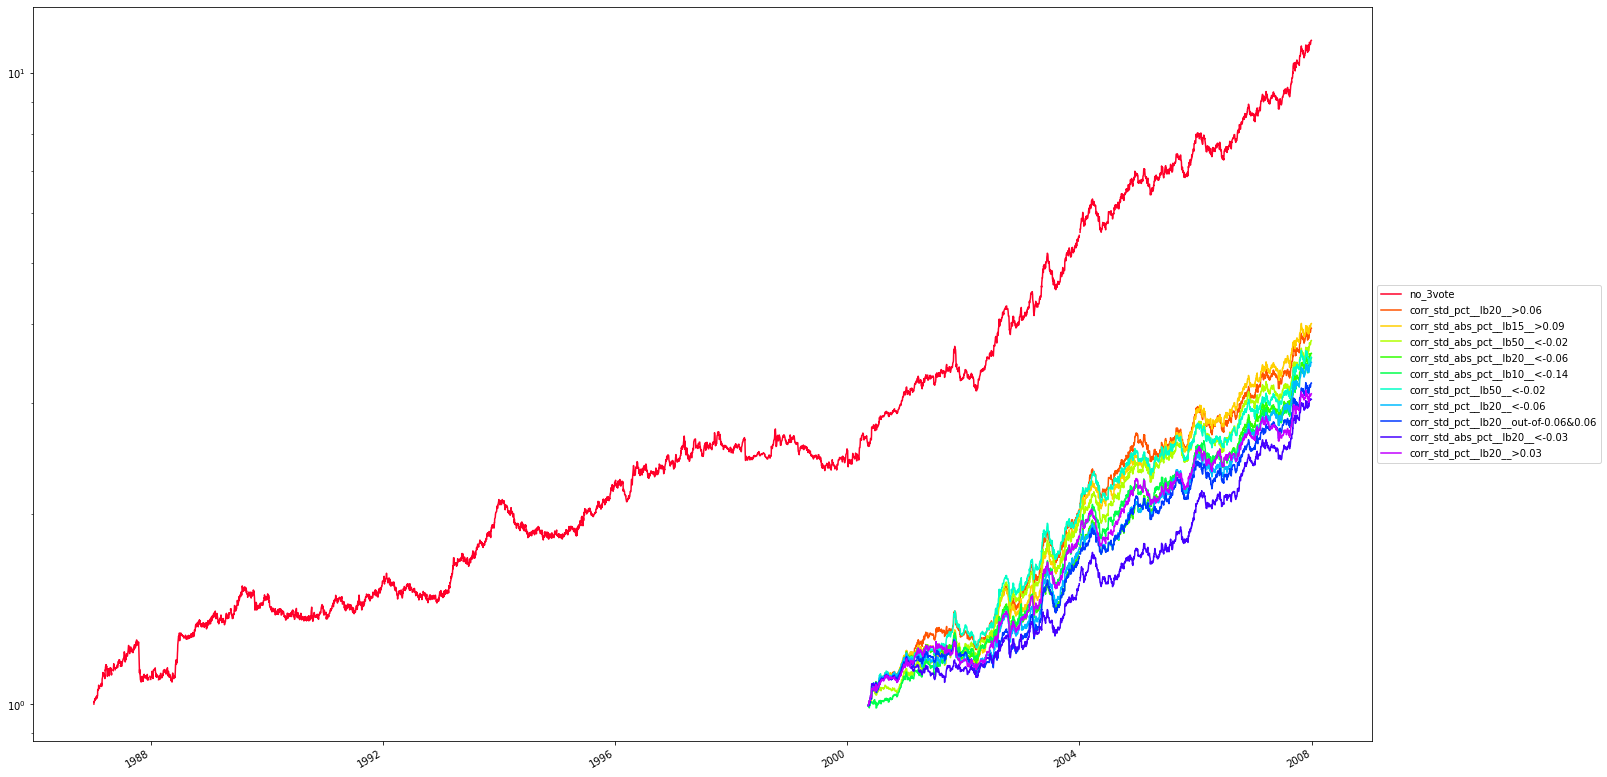

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,up_ratio,buy_ratio,flip_ratio
corr_std_pct__lb20__>0.06,2.942988,0.065343,1.587493,0.113709,-0.131307,-0.030663,0.497637,2.130981,0.944179,0.910375,0.162916
corr_std_abs_pct__lb15__>0.09,3.008992,0.066160,1.586150,0.115248,-0.123943,-0.029108,0.533790,2.272864,0.947003,0.914908,0.154893
corr_std_abs_pct__lb50__<-0.02,2.767495,0.063108,1.523754,0.114756,-0.108369,-0.027767,0.582342,2.272784,0.939509,0.902877,0.171638
corr_std_abs_pct__lb20__<-0.06,2.596862,0.060837,1.490267,0.113274,-0.117586,-0.027607,0.517383,2.203682,0.946025,0.913339,0.161870
corr_std_abs_pct__lb10__<-0.14,2.539273,0.060047,1.461790,0.114148,-0.117272,-0.028124,0.512035,2.135056,0.951781,0.922581,0.138496
corr_std_pct__lb50__<-0.02,2.546530,0.060147,1.450722,0.115288,-0.126985,-0.030875,0.473657,1.948124,0.939618,0.903051,0.166754
corr_std_pct__lb20__<-0.06,2.481970,0.059249,1.421049,0.116123,-0.128668,-0.030500,0.460483,1.942588,0.950586,0.920663,0.142683
corr_std_pct__lb20__out-of-0.06&0.06,2.228028,0.055555,1.414375,0.109331,-0.113599,-0.029554,0.489042,1.879787,0.894765,0.831037,0.261992
corr_std_abs_pct__lb20__<-0.03,2.042167,0.052671,1.392298,0.105357,-0.117484,-0.028686,0.448324,1.836116,0.874783,0.798954,0.325484
corr_std_pct__lb20__>0.03,2.103704,0.053644,1.383910,0.108034,-0.125199,-0.031210,0.428470,1.718806,0.878367,0.804708,0.309262


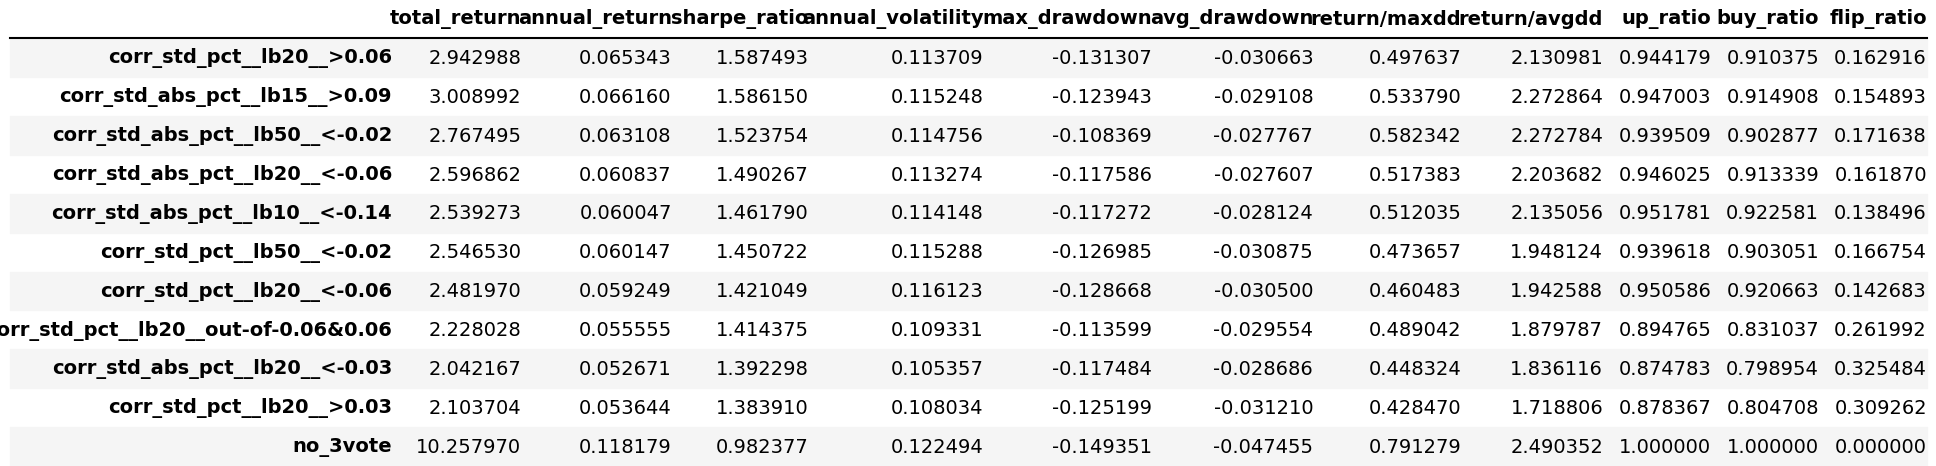

In [53]:
ll = ['no_3vote'] + list(better.index[:10])
show_cum_ret(vote_all_kinds_return_correct_comm_levc[ll])
display_df(better.loc[ll, :].sort_values('sharpe_ratio', ascending=False), export_img=True)

In [ ]:
met_a08 = empy_metric(vote_all_kinds_return_correct_comm_levc['2008':])

ll = ['no_3vote'] + list(met_a08.sort_values('sharpe_ratio', ascending=False).index[:10])
show_cum_ret(vote_all_kinds_return_correct_comm_levc[ll]['2008':])
display_df(met_a08.loc[ll, :].sort_values('sharpe_ratio', ascending=False), export_img=True)

In [ ]:
met_b07 = empy_metric(vote_all_kinds_return_correct_comm_levc[:'2007'])

ll = ['no_3vote'] + list(met_b07.sort_values('sharpe_ratio', ascending=False).index[:10])
show_cum_ret(vote_all_kinds_return_correct_comm_levc[ll][:'2007'])
display_df(met_b07.loc[ll, :].sort_values('sharpe_ratio', ascending=False), export_img=True)

In [61]:
client_weight_agg = {'sharpe_ratio':5,'annual_return':5, 'max_drawdown':5}
def calculation_score(df, client_weight=client_weight_agg):
    df['Sharpe Score'] = df['sharpe_ratio'].apply(lambda x: x if x>0 else 0) * 100
    df['Return Score'] = df['annual_return'].apply(lambda x: 1+x/2) * 100
    df['Max-DD Score'] = df['max_drawdown'].apply(lambda x: 1+x) * 100

    df['Total Score'] = 0
    for score, weight in client_weight.items():
        df['Total Score'] += weight * df[score]
    return df

In [ ]:
save_folder = os.path.join('./result/2022/cashON_signal/result/ret_corr_threshold_v6/')
os.makedirs(save_folder, exist_ok=True)
ret_vote0 = vote_all_kinds_return_correct_comm_levc.copy()

In [65]:
for yy in range(2008, 2018):
# for yy in range(2008, 2023):
    print(yy)
    tmp = ret_vote0[str(yy)]
    print(tmp.index[0], tmp.index[-1])
    met = empy_metric(tmp)
    met = calculation_score(met)
    met.to_csv(os.path.join(save_folder, '{}.csv'.format(yy)))

2008
2008-01-02 00:00:00 2008-12-31 00:00:00
2009
2009-01-02 00:00:00 2009-12-31 00:00:00
2010
2010-01-04 00:00:00 2010-12-31 00:00:00
2011
2011-01-03 00:00:00 2011-12-30 00:00:00
2012
2012-01-03 00:00:00 2012-12-31 00:00:00
2013
2013-01-02 00:00:00 2013-12-31 00:00:00
2014
2014-01-02 00:00:00 2014-12-31 00:00:00


In [63]:
    lookback = [1, 2, 3, 4, 5]
    for lb in lookback:
        print("====================== lookback ========================= ", lb)
        range_s = 2008 + lb
        for yy in range(range_s, 2023):
            print("====================== for year ========================= ", yy)
            try:
                start = yy - lb
                end = yy - 1
                print(start, end)
                if start == end:
                    continue
                tmp = ret_vote0[str(start):str(end)]
                print(tmp.index[0], tmp.index[-1])
                met = empy_metric(tmp)
                met = calculation_score(met)
                met.to_csv(os.path.join(save_folder, 'lookback{}_{}-{}.csv'.format(lb, start, end)))
            except Exception as e:
                print(e)

====================== lookback =========================  1
====================== for year =========================  2009
2008 2008
====================== for year =========================  2010
2009 2009
====================== for year =========================  2011
2010 2010
====================== for year =========================  2012
2011 2011
====================== for year =========================  2013
2012 2012
====================== for year =========================  2014
2013 2013
====================== for year =========================  2015
2014 2014
====================== for year =========================  2016
2015 2015
====================== for year =========================  2017
2016 2016
====================== for year =========================  2018
2017 2017
====================== for year =========================  2019
2018 2018
====================== for year =========================  2020
2019 2019
====================== for year ===================

In [64]:
    range_s = 2009
    start = 2008
    for yy in range(range_s, 2023):
        print("====================== for year ========================= ", yy)
        try:
            end = yy - 1
            print(start, end)
            if start == end:
                continue
            tmp = ret_vote0[str(start):str(end)]
            print(tmp.index[0], tmp.index[-1])
            met = empy_metric(tmp)
            met = calculation_score(met)
            met.to_csv(os.path.join(save_folder, 'extending_{}-{}.csv'.format(start, end)))
        except Exception as e:
            print(e)

====================== for year =========================  2009
2008 2008
====================== for year =========================  2010
2008 2009
2008-01-02 00:00:00 2009-12-31 00:00:00
====================== for year =========================  2011
2008 2010
2008-01-02 00:00:00 2010-12-31 00:00:00
====================== for year =========================  2012
2008 2011
2008-01-02 00:00:00 2011-12-30 00:00:00
====================== for year =========================  2013
2008 2012
2008-01-02 00:00:00 2012-12-31 00:00:00
====================== for year =========================  2014
2008 2013
2008-01-02 00:00:00 2013-12-31 00:00:00
====================== for year =========================  2015
2008 2014
2008-01-02 00:00:00 2014-12-31 00:00:00
====================== for year =========================  2016
2008 2015
2008-01-02 00:00:00 2015-12-31 00:00:00
====================== for year =========================  2017
2008 2016
2008-01-02 00:00:00 2016-12-30 00:00:00
==============

In [62]:
ll = list(better.index)

count_ll = []
for yy in range(2008, 2023):
#     show_cum_ret(vote_all_kinds_return_correct_comm_levc[ll][str(yy)])
    met = empy_metric(vote_all_kinds_return_correct_comm_levc[ll][str(yy)])

    met['up_ratio'] = vote_all_kinds[ll][str(yy)].applymap(lambda x: 0 if x<0.99 else 1).mean()
    met['buy_ratio'] = vote_all_kinds[ll][str(yy)].mean()
    met['flip_ratio'] = flip[ll][str(yy)].mean()
#     display_df(met.sort_values('sharpe_ratio', ascending=False), export_img=True)
    
    base_sharpe = met.loc['no_3vote', 'sharpe_ratio']
    met = met[met['sharpe_ratio']>=base_sharpe]
    ll = list(met.index)
    count_ll += list(met.index)
#     break

In [ ]:
count_ratio = pd.Series(count_ll).value_counts()/len(range(2008, 2023))
count_ratio.plot()

In [ ]:
display(count_ratio[count_ratio == 1])
ll = count_ratio[count_ratio == 1].index
show_cum_ret(vote_all_kinds_return_correct_comm_levc[ll])
display_df(better.loc[ll, :].sort_values('sharpe_ratio', ascending=False), export_img=True)

In [ ]:
display(count_ratio[(count_ratio>=0.5)&(count_ratio!=1)])
ll = list(count_ratio[(count_ratio>=0.5)&(count_ratio!=1)].index) + ['no_3vote']
show_cum_ret(vote_all_kinds_return_correct_comm_levc[ll])
display_df(better.loc[ll, :].sort_values('sharpe_ratio', ascending=False), export_img=True)